In [95]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import datetime
import os

In [82]:
#Seven-Day Load Forecast by Weather Zone URL
url = 'http://mis.ercot.com/misapp/GetReports.do?reportTypeId=12312&reportTitle=Seven-Day%20Load%20Forecast%20by%20Weather%20Zone&showHTMLView=&mimicKey'

In [83]:
response = requests.get(url)

In [84]:
soup = bs(response.text, 'html.parser')

In [85]:
title_results = soup.find_all('td', class_='labelOptional_ind')

In [86]:
# for result in title_results:
#     print(result.text)

In [87]:
url_results = soup.find_all('td', class_='labelOptional', text=True)

In [88]:
base_url = 'http://mis.ercot.com'

data_urls = []

for result in url_results:
    try:
        end_url = result.find('div').a['href']
        full_url = base_url + end_url
        data_urls.append(full_url)
        #print(full_url)
    except:
        pass

## Extract Zip File from URL

In [89]:
data = requests.get(data_urls[0], stream=True)

In [90]:
import requests, zipfile, io

In [91]:
z = zipfile.ZipFile(io.BytesIO(data.content))

In [92]:
z.extractall()

In [93]:
file = z.namelist()[0]

In [96]:
#load zip file to df
load_fcst = pd.read_csv(file)

#delete zip file after reading
os.remove(file)

In [97]:
load_fcst

,DeliveryDate,HourEnding,Coast,East,FarWest,North,NorthCentral,SouthCentral,Southern,West,SystemTotal,DSTFlag
0,07/26/2020,1:00,11329.2998,1586.5800,3972.2500,1010.7800,14263.7002,6922.5698,2779.8799,1377.08,43242.1397,N
1,07/26/2020,2:00,11116.2998,1518.3300,3879.0300,965.5820,13484.7998,6488.8701,2582.1399,1328.29,41363.3416,N
2,07/26/2020,3:00,10999.5000,1449.6000,3829.1201,914.5130,12684.0996,6384.8301,2572.1399,1216.38,40050.1827,N
3,07/26/2020,4:00,10748.7002,1393.6200,3774.9299,873.9960,12087.0996,6229.7900,2503.7100,1133.60,38745.4457,N
4,07/26/2020,5:00,10718.2002,1357.1600,3736.2100,862.4670,12002.2998,6224.9399,2429.9600,1198.46,38529.6969,N
...,...,...,...,...,...,...,...,...,...,...,...,...
187,08/02/2020,20:00,15944.2002,2153.4600,4371.1201,1364.4800,20345.8008,11051.5000,4799.5098,2023.02,62053.0909,N
188,08/02/2020,21:00,15963.5996,2092.6799,4347.6001,1321.1100,19510.5000,10651.0996,4701.8501,1971.14,60559.5793,N
189,08/02/2020,22:00,15561.5000,2035.8500,4299.7202,1265.1500,18675.1992,10236.2998,4637.4399,1917.78,58628.9391,N
190,08/02/2020,23:00,14898.5000,1894.7000,4155.9102,1172.1801,17470.3008,9565.6201,4404.7402,1830.22,55392.1714,N


In [98]:
#clean existing columns
load_fcst['DeliveryDate'] = pd.to_datetime(load_fcst.DeliveryDate).dt.normalize()
load_fcst['HourEnding'] = load_fcst.HourEnding.str.split(':').str[0]

#add file name and process info to df
load_fcst['FileName'] = z.namelist()[0]
load_fcst['ProcessDate'] = pd.to_datetime(load_fcst.FileName.str.split('.').str[3]).dt.normalize()
load_fcst['ProcessHour'] = load_fcst.FileName.str.split('.').str[4]
load_fcst['ProcessDT'] = pd.to_datetime(load_fcst.FileName.str.split('.').str[3] + load_fcst.FileName.str.split('.').str[4])

#add delivery date time
load_fcst['DeliveryDT'] = pd.to_datetime(load_fcst.DeliveryDate) + load_fcst.HourEnding.astype('timedelta64[h]')

#add weekday columns
load_fcst['Weekday'] = load_fcst.DeliveryDT.dt.day_name()


In [99]:
load_fcst.head()

,DeliveryDate,HourEnding,Coast,East,FarWest,North,NorthCentral,SouthCentral,Southern,West,SystemTotal,DSTFlag,FileName,ProcessDate,ProcessHour,ProcessDT,DeliveryDT,Weekday
0,2020-07-26,1,11329.2998,1586.58,3972.2500,1010.780,14263.7002,6922.5698,2779.8799,1377.08,43242.1397,N,cdr.00012312.0000000000000000.20200726.223000....,2020-07-26,223000,2020-07-26 22:30:00,2020-07-26 01:00:00,Sunday
1,2020-07-26,2,11116.2998,1518.33,3879.0300,965.582,13484.7998,6488.8701,2582.1399,1328.29,41363.3416,N,cdr.00012312.0000000000000000.20200726.223000....,2020-07-26,223000,2020-07-26 22:30:00,2020-07-26 02:00:00,Sunday
2,2020-07-26,3,10999.5000,1449.60,3829.1201,914.513,12684.0996,6384.8301,2572.1399,1216.38,40050.1827,N,cdr.00012312.0000000000000000.20200726.223000....,2020-07-26,223000,2020-07-26 22:30:00,2020-07-26 03:00:00,Sunday
3,2020-07-26,4,10748.7002,1393.62,3774.9299,873.996,12087.0996,6229.7900,2503.7100,1133.60,38745.4457,N,cdr.00012312.0000000000000000.20200726.223000....,2020-07-26,223000,2020-07-26 22:30:00,2020-07-26 04:00:00,Sunday
4,2020-07-26,5,10718.2002,1357.16,3736.2100,862.467,12002.2998,6224.9399,2429.9600,1198.46,38529.6969,N,cdr.00012312.0000000000000000.20200726.223000....,2020-07-26,223000,2020-07-26 22:30:00,2020-07-26 05:00:00,Sunday


In [100]:
load_fcst.describe()

,Coast,East,FarWest,North,NorthCentral,SouthCentral,Southern,West,SystemTotal
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,14324.997909,1882.838022,4019.515374,1148.064322,16759.154699,8557.971093,3835.395518,1658.400418,52186.337355
std,2159.632789,325.701827,215.666883,204.337760,3231.090727,1611.479311,710.549237,248.418293,8508.404419
min,10566.200200,1284.850000,3621.310100,835.041000,11788.700200,6161.620100,2357.290000,1133.600000,37987.388200
25%,12372.975100,1574.770000,3810.140025,952.158750,13573.449950,7047.005000,3260.562400,1445.857500,44121.092100
50%,14236.049800,1894.640000,4020.070100,1136.550000,16676.450200,8551.029800,3753.545050,1614.835050,52268.320200
75%,16221.775400,2180.512500,4226.482400,1331.167500,19700.725100,9941.192625,4386.894875,1886.777475,60074.868975
max,18407.900400,2456.230000,4423.100100,1538.400000,22946.099600,11592.299800,5250.770000,2099.379900,68193.340600


In [101]:
load_fcst.dtypes

DeliveryDate    datetime64[ns]
HourEnding              object
Coast                  float64
East                   float64
FarWest                float64
North                  float64
NorthCentral           float64
SouthCentral           float64
Southern               float64
West                   float64
SystemTotal            float64
DSTFlag                 object
FileName                object
ProcessDate     datetime64[ns]
ProcessHour             object
ProcessDT       datetime64[ns]
DeliveryDT      datetime64[ns]
Weekday                 object
dtype: object

In [102]:
z.namelist()[0]

'cdr.00012312.0000000000000000.20200726.223000.LFCWEATHERNP3561.csv'

### Convert DF to Long Format (i.e. Unpivot Forecast columns)

In [72]:
#use pd.melt to unpivot columns
long_load_fcst = pd.melt(load_fcst, id_vars=['DeliveryDate', 'Weekday', 'HourEnding', 'DSTFlag', 'FileName', 'ProcessDate', 'ProcessHour', 'ProcessDT', 'DeliveryDT'],var_name='WeatherZone', value_name ='MW')

#reorganize columns
columns = ['DeliveryDT', 'DeliveryDate', 'Weekday', 'HourEnding', 'DSTFlag', 'WeatherZone', 'MW', 'ProcessDate', 'ProcessHour', 'ProcessDT', 'FileName']


long_load_fcst = long_load_fcst[columns]
long_load_fcst

,DeliveryDT,DeliveryDate,Weekday,HourEnding,DSTFlag,WeatherZone,MW,ProcessDate,ProcessHour,ProcessDT,FileName
0,2020-07-26 01:00:00,2020-07-26,Sunday,1,N,Coast,11329.2998,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
1,2020-07-26 02:00:00,2020-07-26,Sunday,2,N,Coast,11116.2998,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
2,2020-07-26 03:00:00,2020-07-26,Sunday,3,N,Coast,10999.5000,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
3,2020-07-26 04:00:00,2020-07-26,Sunday,4,N,Coast,10748.7002,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
4,2020-07-26 05:00:00,2020-07-26,Sunday,5,N,Coast,10718.2002,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
...,...,...,...,...,...,...,...,...,...,...,...
1723,2020-08-02 20:00:00,2020-08-02,Sunday,20,N,SystemTotal,61980.8105,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
1724,2020-08-02 21:00:00,2020-08-02,Sunday,21,N,SystemTotal,60434.3512,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
1725,2020-08-02 22:00:00,2020-08-02,Sunday,22,N,SystemTotal,58590.9799,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
1726,2020-08-02 23:00:00,2020-08-02,Sunday,23,N,SystemTotal,55288.5008,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....


## Plotting Forecasts

In [73]:
import plotly.express as px
#import plotly.io as pio
#pio.renderers.default = "svg"

In [74]:
system_df = long_load_fcst.loc[long_load_fcst.WeatherZone == 'SystemTotal', :] 

system_df.head()

systemFig = px.line(system_df, x="DeliveryDT", y="MW", title='System Level Forecasts')

systemFig.show()

In [75]:
wz_df = long_load_fcst.loc[long_load_fcst.WeatherZone != 'SystemTotal', :] 

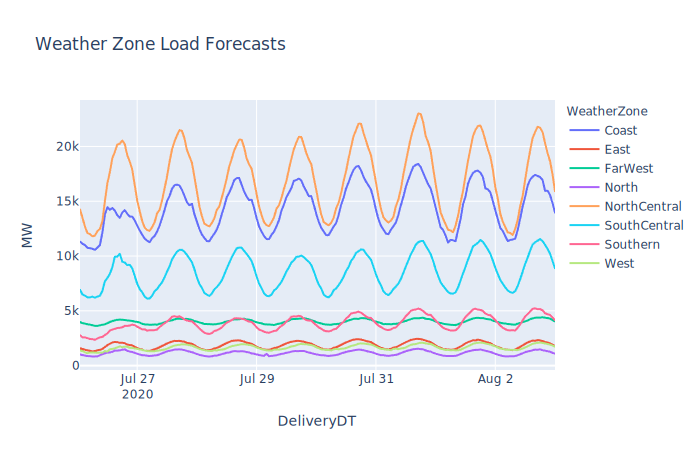

In [76]:
wzFig = px.line(wz_df, x='DeliveryDT', y='MW', color='WeatherZone', title='Weather Zone Load Forecasts')
wzFig.show('svg')

## Load Data to PostgreSQL Database

In [77]:
from sqlalchemy import create_engine

In [78]:
connection_string = f"postgres:trumpet5@localhost:5432/ercot_db"
engine = create_engine(f'postgresql://{connection_string}')

In [79]:
#fill table
long_load_fcst.to_sql(name='da_load_fcst', con=engine, if_exists='append', index=False)

In [80]:
#Print Table
pd.read_sql_query('select * from da_load_fcst', con=engine)

,DeliveryDT,DeliveryDate,Weekday,HourEnding,DSTFlag,WeatherZone,MW,ProcessDate,ProcessHour,ProcessDT,FileName
0,2020-07-26 01:00:00,2020-07-26,Sunday,1,N,Coast,11329.2998,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
1,2020-07-26 02:00:00,2020-07-26,Sunday,2,N,Coast,11116.2998,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
2,2020-07-26 03:00:00,2020-07-26,Sunday,3,N,Coast,10999.5000,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
3,2020-07-26 04:00:00,2020-07-26,Sunday,4,N,Coast,10748.7002,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
4,2020-07-26 05:00:00,2020-07-26,Sunday,5,N,Coast,10718.2002,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
...,...,...,...,...,...,...,...,...,...,...,...
1723,2020-08-02 20:00:00,2020-08-02,Sunday,20,N,SystemTotal,61980.8105,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
1724,2020-08-02 21:00:00,2020-08-02,Sunday,21,N,SystemTotal,60434.3512,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
1725,2020-08-02 22:00:00,2020-08-02,Sunday,22,N,SystemTotal,58590.9799,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
1726,2020-08-02 23:00:00,2020-08-02,Sunday,23,N,SystemTotal,55288.5008,2020-07-26,203000,2020-07-26 20:30:00,cdr.00012312.0000000000000000.20200726.203000....
